In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [3]:
header = ["age", "workclass", "fnlwgt", "edu", "edu-num", "marital-status", "occupation", "relationship", "race", "sex", "gain", "loss", "hrs/week", "native-country", "income"]
df = pd.read_csv('adult/adult.data', low_memory = False, names=header)

In [4]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (32561, 15)


,age,workclass,fnlwgt,edu,edu-num,marital-status,occupation,relationship,race,sex,gain,loss,hrs/week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Checking missing values
print("\nMissing values per column:")
for col in df.columns:
    missing_count = (df[col] == ' ?').sum()
    if missing_count > 0:
        print(f"{col}: {missing_count}")


Missing values per column:
workclass: 1836
occupation: 1843
native-country: 583


In [6]:
#Replacing values with unhandled values
for col in df.columns:
    df[col] = df[col].replace(' ?', np.nan)
    
# Convert target variable to binary (1 for >50K, 0 for <=50K)
df['income'] = np.where(df['income'].str.contains('>50K', na=False), 1, 0)

# Separate features and target
X = df.drop('income', axis=1)
y = df['income']

print("\nClass distribution:  (1 = >50l)")
print(y.value_counts(normalize=True) * 100)


Class distribution:  (1 = >50l)
income
0    75.919044
1    24.080956
Name: proportion, dtype: float64


In [7]:
# Identifying categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical features:", categorical_features)
print("Numerical features:", numerical_features)


Categorical features: ['workclass', 'edu', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numerical features: ['age', 'fnlwgt', 'edu-num', 'gain', 'loss', 'hrs/week']


In [8]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (26048, 14)
Testing set shape: (6513, 14)


In [9]:
# Creating preprocessing pipelines
# Numerical pipeline: impute missing values with median and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [10]:
# Categorical pipeline: impute missing values with most frequent value and one-hot encode
# Using sparse=False instead of sparse_output=False for older scikit-learn versions
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [11]:
# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [12]:
# Creating the full pipeline with different regularizations
model1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=1.0, max_iter=1000, random_state=123))
])

model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.1, max_iter=1000, random_state=123))
])

model3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=10.0, max_iter=1000, random_state=123))
])

In [13]:
# Training the model
print("\nTraining the logistic regression models...")
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)


Training the logistic regression models...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt', 'edu-num',
                                                   'gain', 'loss',
                                                   'hrs/week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['workclass', 'edu',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=1000, random_state=123))])

In [17]:
# Evaluating on training data
y_train_pred1 = model1.predict(X_train)
train_accuracy1 = accuracy_score(y_train, y_train_pred1)
train_error_rate1 = 1 - train_accuracy1
print("\nModel 1 (1.0 Regularization) Training Results:")
print(f"Training accuracy: {train_accuracy1:.4f}")
print(f"Training error rate: {train_error_rate1:.4f}")

# Evaluating on training data
y_train_pred2 = model2.predict(X_train)
train_accuracy2 = accuracy_score(y_train, y_train_pred2)
train_error_rate2 = 1 - train_accuracy2
print("\nModel 2 (0.1 Regularization) Training Results:")
print(f"Training accuracy: {train_accuracy2:.4f}")
print(f"Training error rate: {train_error_rate2:.4f}")

# Evaluating on training data
y_train_pred3 = model3.predict(X_train)
train_accuracy3 = accuracy_score(y_train, y_train_pred3)
train_error_rate3 = 1 - train_accuracy3
print("\nModel 3 (10 Regularization) Training Results:")
print(f"Training accuracy: {train_accuracy3:.4f}")
print(f"Training error rate: {train_error_rate3:.4f}")


Model 1 (1.0 Regularization) Training Results:
Training accuracy: 0.8511
Training error rate: 0.1489

Model 2 (0.1 Regularization) Training Results:
Training accuracy: 0.8514
Training error rate: 0.1486

Model 3 (10 Regularization) Training Results:
Training accuracy: 0.8515
Training error rate: 0.1485


In [16]:
# Evaluating on testing data
y_test_pred1 = model1.predict(X_test)
test_accuracy1 = accuracy_score(y_test, y_test_pred1)
test_error_rate1 = 1 - test_accuracy1

print("\nModel 1 (1.0 Regularization) Training Results:")
print(f"Testing accuracy: {test_accuracy1:.4f}")
print(f"Testing error rate: {test_error_rate1:.4f}")

# Evaluating on testing data
y_test_pred2 = model2.predict(X_test)
test_accuracy2 = accuracy_score(y_test, y_test_pred2)
test_error_rate2 = 1 - test_accuracy2

print("\nModel 2 (0.1 Regularization) Training Results:")
print(f"Testing accuracy: {test_accuracy2:.4f}")
print(f"Testing error rate: {test_error_rate2:.4f}")

# Evaluating on testing data
y_test_pred3 = model3.predict(X_test)
test_accuracy3 = accuracy_score(y_test, y_test_pred3)
test_error_rate3 = 1 - test_accuracy3

print("\nModel 3 (10 Regularization) Training Results:")
print(f"Testing accuracy: {test_accuracy3:.4f}")
print(f"Testing error rate: {test_error_rate3:.4f}")


Model 1 (1.0 Regularization) Training Results:
Testing accuracy: 0.8538
Testing error rate: 0.1462

Model 2 (0.1 Regularization) Training Results:
Testing accuracy: 0.8535
Testing error rate: 0.1465

Model 3 (10 Regularization) Training Results:
Testing accuracy: 0.8532
Testing error rate: 0.1468


In [78]:
# Printing classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4945
           1       0.75      0.59      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513




ROC AUC Score: 0.9025


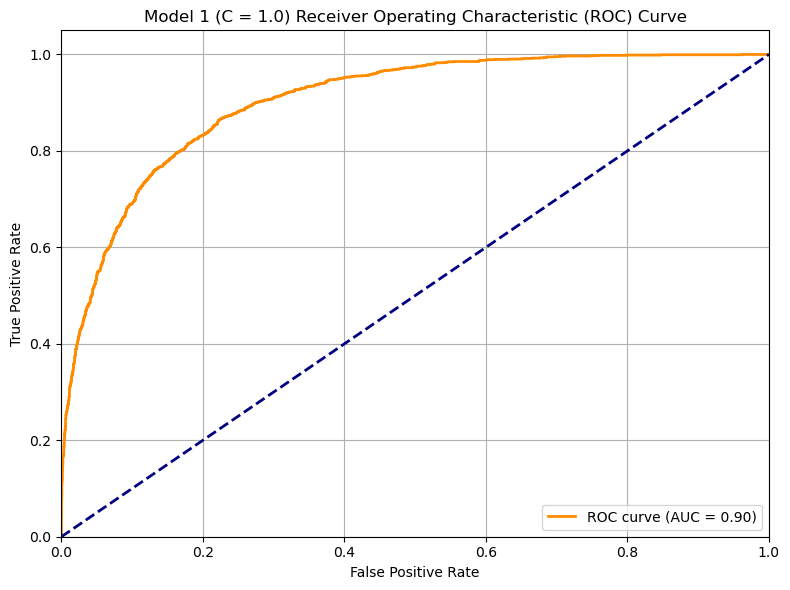


ROC AUC Score: 0.9022


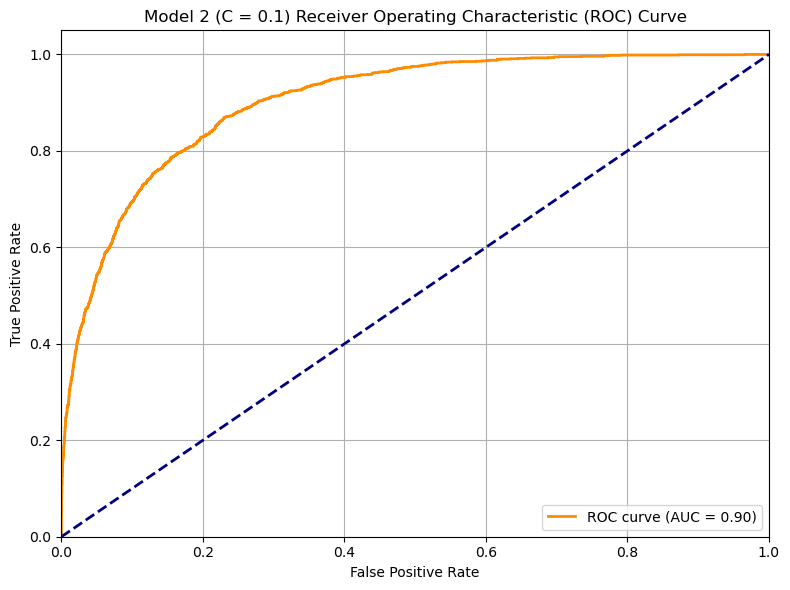


ROC AUC Score: 0.9023


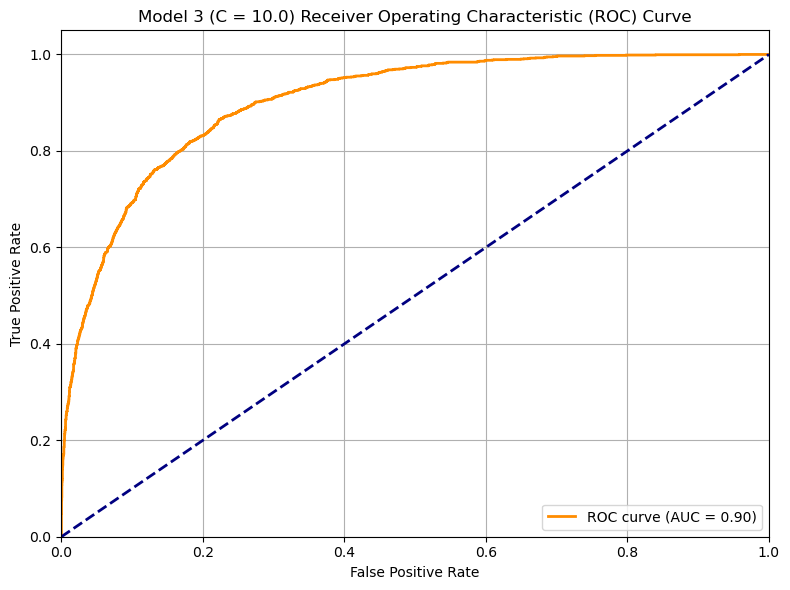

In [18]:
# Calculating ROC curve and AUC
y_test_proba = model1.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 1 (C = 1.0) Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model 2
y_test_proba = model2.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 2 (C = 0.1) Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model 3
y_test_proba = model3.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 3 (C = 10.0) Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Coefficients of the features and plotting them
try:
    # Get the logistic regression coefficients
    coefficients = model.named_steps['classifier'].coef_[0]
    
    # Get feature names after preprocessing
    feature_names = []
    
    # Get transformed feature names
    for name, transformer, features in model.named_steps['preprocessor'].transformers_:
        if name == 'cat':
            # Get the one-hot encoder categories
            ohe = transformer.named_steps['onehot']
            categories = ohe.categories_
            
            # Create feature names for each category
            for i, category in enumerate(categories):
                feature_names.extend([f"{features[i]}_{c.strip()}" for c in category])
        else:  # 'num'
            feature_names.extend(features)
    
    # Create a DataFrame with features and their coefficients
    if len(coefficients) == len(feature_names):
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        })
        
        # Sort by absolute value of coefficient
        feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
        feature_importance = feature_importance.sort_values('AbsCoefficient', ascending=False)
        
        # Plot the top 20 features
        plt.figure(figsize=(12, 10))
        top_features = feature_importance.head(20)
        sns.barplot(x='Coefficient', y='Feature', data=top_features)
        plt.title('Top 20 Feature Importances')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
        
        # Print the top 10 most important features
        print("\nTop 10 Most Important Features:")
        print(feature_importance[['Feature', 'Coefficient']].head(10))
except Exception as e:
    print(f"\nCould not extract feature importances: {e}")

# Print final results
print("\nFinal Results:")
print(f"Model 1 Training Error Rate: {train_error_rate1:.4f}")
print(f"Model 1 Testing Error Rate: {test_error_rate1:.4f}")
print(f"Model 2 Training Error Rate: {train_error_rate2:.4f}")
print(f"Model 2 Testing Error Rate: {test_error_rate2:.4f}")
print(f"Model 3 Training Error Rate: {train_error_rate3:.4f}")
print(f"Model 3 Testing Error Rate: {test_error_rate3:.4f}")


Could not extract feature importances: name 'model' is not defined

Final Results:
Model 1 Training Error Rate: 0.1489
Model 1 Testing Error Rate: 0.1462
Model 2 Training Error Rate: 0.1486
Model 2 Testing Error Rate: 0.1465
Model 3 Training Error Rate: 0.1485
Model 3 Testing Error Rate: 0.1468
